# Opposite Emotion Tweet Generation and Evaluation

This notebook will guide you through the process of:
- Extracting a sample of tweets from your dataset
- Computing their emotion scores
- Generating opposite-emotion tweets using various LLMs (OpenAI, Gemini, etc.)
- Comparing the emotion scores of generated datasets to select the best model

---

## 1. Set Up the Jupyter Notebook Environment

Ensure the notebook is running in the correct Python environment.

In [1]:
# Check Python version and current working directory
import sys, os
print(f"Python version: {sys.version}")
print(f"Current working directory: {os.getcwd()}")

Python version: 3.10.12 (main, May 27 2025, 17:12:29) [GCC 11.4.0]
Current working directory: /home/mateja/Documents/IJS/current/Our Agents/Multi-Domain-Agents/notebooks


In [3]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests

In [4]:
# Print versions of Python and imported libraries
import sys
print(f"Python: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {plt.matplotlib.__version__}")
import requests
print(f"requests: {requests.__version__}")

Python: 3.10.12 (main, May 27 2025, 17:12:29) [GCC 11.4.0]
numpy: 2.2.6
pandas: 2.3.1
matplotlib: 3.10.5
requests: 2.32.4


In [5]:
# Simple test cell to verify code execution
print("Notebook is set up and running!")

Notebook is set up and running!


## 2. Extract a Sample of 50 Tweets

We will extract the first 50 tweets from `data/sample_raw/tech_tweets2.jsonl` and display a preview.

In [11]:
# Load and inspect the tweet data using pandas for robustness
import pandas as pd

sample_path = "../data/sample_raw/tech_tweets2.jsonl"
df = pd.read_json(sample_path, lines=True)

# Show the first few rows and columns
print(df.head())
print("\nColumns:", df.columns.tolist())

# Use the correct text column for tweets
text_col = 'full_text'  # Changed from 'text' to 'full_text' based on data inspection
if text_col not in df.columns:
    raise ValueError(f"Column '{text_col}' not found in data. Available columns: {df.columns.tolist()}")

tweets = df[text_col].astype(str).head(50).tolist()

# Show a preview of the first 5 tweets
for idx, tweet in enumerate(tweets[:5]):
    print(f"Tweet {idx+1}: {tweet}\n")
print(f"Total tweets extracted: {len(tweets)}")

                 created_at                   id               id_str  \
0 2019-04-30 22:57:41+00:00  1123360805364338690  1123360805364338688   
1 2019-05-01 00:33:12+00:00  1123384843029700608  1123384843029700608   
2 2019-05-01 08:37:02+00:00  1123506604417196032  1123506604417196032   
3 2019-05-01 09:58:49+00:00  1123527183157297153  1123527183157297152   
4 2019-05-01 20:57:00+00:00  1123692823348436992  1123692823348436992   

                                           full_text  truncated  \
0  @USCapGlobal appoints additional Vice Presiden...      False   
1  💌The Ladies at @letters4trump45 are AMAZING Wa...      False   
2  Feeling cute. Might send my squadron at suicid...      False   
3  @ArbitradeX $dig\n\nImportant enough to be men...      False   
4  New report reveals that the UK police are secr...      False   

  display_text_range                                           entities  \
0           [0, 266]  {'hashtags': [{'text': 'businessgrowth', 'indi...   
1       

## 3. Compute Emotion Scores for the Sample Tweets

We will use the external API to compute emotion scores for the 50 extracted tweets.

In [12]:
# Compute emotion scores for the 50 tweets using the external API
import requests
import time

api_url = "https://metrics.twon.uni-trier.de/"
headers = {"accept": "application/json", "Content-Type": "application/json"}

# The API may have a limit on batch size; adjust if needed
payload = {"samples": tweets, "threshold": 0.5}
response = requests.post(api_url, json=payload, headers=headers)

if response.status_code == 200:
    result = response.json()
    scores = result.get("predictions", [])
    print(f"Received {len(scores)} emotion score results.")
    # Show a preview of the first 3 results
    for i, (tweet, score) in enumerate(zip(tweets, scores[:3])):
        print(f"\nTweet {i+1}: {tweet}\nScores: {score}")
else:
    print(f"API request failed with status code {response.status_code}: {response.text}")

Received 50 emotion score results.

Tweet 1: @USCapGlobal appoints additional Vice President, Pankaj Vashisth, following a year of strong #businessgrowth across multiple verticals. Read more: https://t.co/c116uauLou
#fintech #regtech #investment #advisory #innovation #HighTech #debt #equity #finance #investors https://t.co/Je6yCZ4yBw
Scores: {'sample': '@USCapGlobal appoints additional Vice President, Pankaj Vashisth, following a year of strong #businessgrowth across multiple verticals. Read more: https://t.co/c116uauLou\n#fintech #regtech #investment #advisory #innovation #HighTech #debt #equity #finance #investors https://t.co/Je6yCZ4yBw', 'results': {'topics': {'business_&_entrepreneurs': 0.9624882936477661, 'news_&_social_concern': 0.6990002393722534}, 'emotions': {'anticipation': 0.593111515045166, 'joy': 0.9063214063644409, 'optimism': 0.8527327179908752}, 'sentiment': {'neutral': 0.6611718535423279, 'positive': 0.9081242680549622}, 'irony': {'non_irony': 0.804801344871521}, 'off

### Save and Visualize Emotion Scores

We will save the emotion scores to a JSON file and visualize the distribution of each emotion across the 50 tweets.

In [14]:
# Extract emotion scores using the same logic as compare.py

def extract_emotion_scores(item):
    results = item.get('results', {})
    return {
        'hate': results.get('hate', {}).get('HATE', 0),
        'not_hate': results.get('hate', {}).get('NOT-HATE', 0),
        'non_offensive': results.get('offensive', {}).get('non-offensive', 0),
        'irony': results.get('irony', {}).get('irony', 0),
        'neutral': results.get('sentiment', {}).get('neutral', 0),
        'positive': results.get('sentiment', {}).get('positive', 0),
        'negative': results.get('sentiment', {}).get('negative', 0),
    }

# Apply extraction to all API results
flat_scores = [extract_emotion_scores(item) for item in scores]

# Preview the first 3 extracted scores
for i, (tweet, score) in enumerate(zip(tweets, flat_scores[:3])):
    print(f'Tweet {i+1}: {tweet}\nScores: {score}\n')

Tweet 1: @USCapGlobal appoints additional Vice President, Pankaj Vashisth, following a year of strong #businessgrowth across multiple verticals. Read more: https://t.co/c116uauLou
#fintech #regtech #investment #advisory #innovation #HighTech #debt #equity #finance #investors https://t.co/Je6yCZ4yBw
Scores: {'hate': 0, 'not_hate': 0.9549048542976379, 'non_offensive': 0.7691205739974976, 'irony': 0, 'neutral': 0.6611718535423279, 'positive': 0.9081242680549622, 'negative': 0}

Tweet 2: 💌The Ladies at @letters4trump45 are AMAZING Warrior #Patriots💌

😢And now they need our support😢

🤕👉https://t.co/5EgFdooacJ👈🤕

👊#PatriotsUnite - Let's Show Them What #WWG1WGA Means👊

❤️@POTUS @realDonaldTrump❤️
🙏#ClearFlynnNow @GenFlynn🙏
🇺🇸#MAGA #KAG #TrumpsArmy 🇺🇸 https://t.co/I3SOeECdYj
Scores: {'hate': 0, 'not_hate': 0.9555691480636597, 'non_offensive': 0.7412661910057068, 'irony': 0, 'neutral': 0, 'positive': 0.735284686088562, 'negative': 0}

Tweet 3: Feeling cute. Might send my squadron at suicide mis

Saved flat emotion scores to sample_50_tweets_with_flat_scores.json


/tmp/ipykernel_228386/1147920010.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(emotion_matrix, labels=emotions)


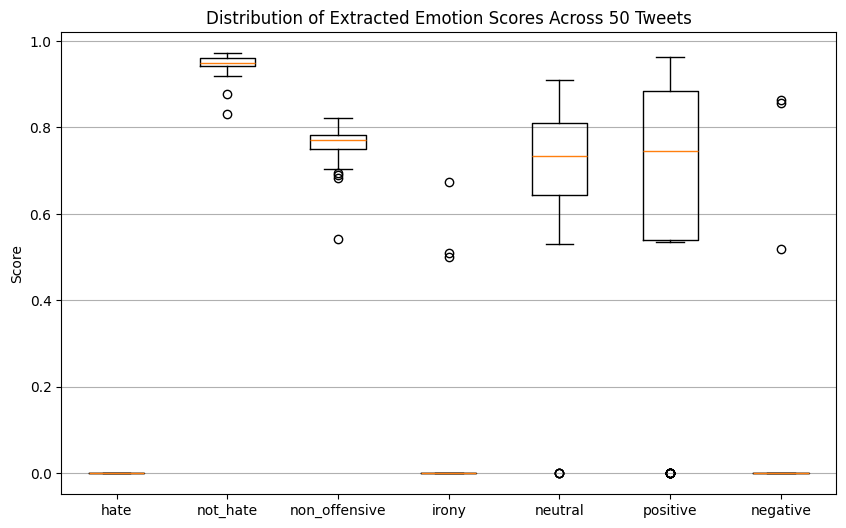

In [16]:
# Save flat emotion scores to a JSON file and visualize distributions
import json
import matplotlib.pyplot as plt
import numpy as np

# Save the flat scores and tweets for reproducibility
with open("sample_50_tweets_with_flat_scores.json", "w", encoding="utf-8") as f:
    json.dump({"tweets": tweets, "flat_scores": flat_scores}, f, indent=2, ensure_ascii=False)
print("Saved flat emotion scores to sample_50_tweets_with_flat_scores.json")

# List of emotions (consistent with extraction)
emotions = ["hate", "not_hate", "non_offensive", "irony", "neutral", "positive", "negative"]

# Prepare data for visualization
emotion_matrix = np.array([[score.get(e, 0) for e in emotions] for score in flat_scores])

plt.figure(figsize=(10, 6))
plt.boxplot(emotion_matrix, labels=emotions)
plt.title("Distribution of Extracted Emotion Scores Across 50 Tweets")
plt.ylabel("Score")
plt.grid(axis='y')
plt.show()

### Understanding Emotion Scores

Each tweet is evaluated for the following emotions or categories:

- **hate**: Probability the tweet is hateful (0 = not hateful, 1 = definitely hateful)
- **not_hate**: Probability the tweet is not hateful (0 = definitely hateful, 1 = definitely not hateful)
- **non_offensive**: Probability the tweet is not offensive (0 = definitely offensive, 1 = definitely not offensive)
- **irony**: Probability the tweet is ironic (0 = not ironic, 1 = definitely ironic)
- **neutral**: Probability the tweet is neutral in sentiment (0 = not neutral, 1 = definitely neutral)
- **positive**: Probability the tweet is positive in sentiment (0 = not positive, 1 = definitely positive)
- **negative**: Probability the tweet is negative in sentiment (0 = not negative, 1 = definitely negative)

**All scores are on a scale from 0 to 1.**

Below, we show the average score for each emotion across the 50 tweets in a readable table.

In [18]:
# Show a readable table of average emotion scores for the 50 tweets
import pandas as pd

# Create DataFrame for easier viewing
flat_scores_df = pd.DataFrame(flat_scores)
avg_scores = flat_scores_df.mean().to_frame(name='Average Score')

# Display as a simple table (no .style formatting)
print("Average emotion scores across 50 tweets:")
print(avg_scores.round(3))

Average emotion scores across 50 tweets:
               Average Score
hate                   0.000
not_hate               0.947
non_offensive          0.763
irony                  0.034
neutral                0.677
positive               0.607
negative               0.045


In [19]:
# Save each tweet with its flat emotion scores as metadata for LLM prompting
import json

tweets_with_metadata = []
for tweet, score in zip(tweets, flat_scores):
    tweets_with_metadata.append({
        "tweet": tweet,
        "emotion_scores": score
    })

with open("sample_50_tweets_with_metadata.json", "w", encoding="utf-8") as f:
    json.dump(tweets_with_metadata, f, indent=2, ensure_ascii=False)

print(f"Saved 50 tweets with emotion score metadata to sample_50_tweets_with_metadata.json")

Saved 50 tweets with emotion score metadata to sample_50_tweets_with_metadata.json


In [20]:
# Filter tweets: keep only those with positive or negative score > 0, and save only these scores as metadata
filtered_tweets_with_metadata = []
for tweet, score in zip(tweets, flat_scores):
    pos = score.get('positive', 0)
    neg = score.get('negative', 0)
    if pos > 0 or neg > 0:
        filtered_tweets_with_metadata.append({
            "tweet": tweet,
            "emotion_scores": {"positive": pos, "negative": neg}
        })
    if len(filtered_tweets_with_metadata) == 50:
        break

print(f"Selected {len(filtered_tweets_with_metadata)} tweets with nonzero positive or negative score.")

with open("sample_50_tweets_with_posneg_metadata.json", "w", encoding="utf-8") as f:
    json.dump(filtered_tweets_with_metadata, f, indent=2, ensure_ascii=False)
print("Saved filtered tweets with positive/negative score metadata to sample_50_tweets_with_posneg_metadata.json")

Selected 41 tweets with nonzero positive or negative score.
Saved filtered tweets with positive/negative score metadata to sample_50_tweets_with_posneg_metadata.json


In [22]:
# Collect 50 tweets with nonzero positive or negative score from the entire dataset
import json
import requests

sample_path = "../data/sample_raw/tech_tweets2.jsonl"
collected = []
BATCH_SIZE = 20  # API may have a batch limit; adjust as needed

with open(sample_path, "r", encoding="utf-8") as f:
    buffer = []
    for line in f:
        tweet_obj = json.loads(line)
        tweet = tweet_obj.get("full_text", "")
        buffer.append(tweet)
        if len(buffer) == BATCH_SIZE:
            payload = {"samples": buffer, "threshold": 0.5}
            response = requests.post("https://metrics.twon.uni-trier.de/", json=payload, headers={"accept": "application/json", "Content-Type": "application/json"})
            if response.status_code == 200:
                scores = response.json().get("predictions", [])
                for tweet, score in zip(buffer, scores):
                    pos = score.get('results', {}).get('sentiment', {}).get('positive', 0)
                    neg = score.get('results', {}).get('sentiment', {}).get('negative', 0)
                    if pos > 0 or neg > 0:
                        collected.append({
                            "tweet": tweet,
                            "emotion_scores": {"positive": pos, "negative": neg}
                        })
                    if len(collected) == 50:
                        break
            buffer = []
        if len(collected) == 50:
            break
    # Process any remaining tweets in buffer
    if len(collected) < 50 and buffer:
        payload = {"samples": buffer, "threshold": 0.5}
        response = requests.post("https://metrics.twon.uni-trier.de/", json=payload, headers={"accept": "application/json", "Content-Type": "application/json"})
        if response.status_code == 200:
            scores = response.json().get("predictions", [])
            for tweet, score in zip(buffer, scores):
                pos = score.get('results', {}).get('sentiment', {}).get('positive', 0)
                neg = score.get('results', {}).get('sentiment', {}).get('negative', 0)
                if pos > 0 or neg > 0:
                    collected.append({
                        "tweet": tweet,
                        "emotion_scores": {"positive": pos, "negative": neg}
                    })
                if len(collected) == 50:
                    break

print(f"Collected {len(collected)} tweets with nonzero positive or negative score.")
with open("sample_50_tweets_with_posneg_metadata.json", "w", encoding="utf-8") as f:
    json.dump(collected, f, indent=2, ensure_ascii=False)
print("Saved filtered tweets with positive/negative score metadata to sample_50_tweets_with_posneg_metadata.json")

Collected 50 tweets with nonzero positive or negative score.
Saved filtered tweets with positive/negative score metadata to sample_50_tweets_with_posneg_metadata.json


In [23]:
# Generate LLM prompts for each tweet based on its sentiment score (positive or negative)
import json
with open("sample_50_tweets_with_posneg_metadata.json", "r", encoding="utf-8") as f:
    filtered_tweets_with_metadata = json.load(f)

prompts = []
for item in filtered_tweets_with_metadata:
    tweet = item["tweet"]
    pos = item["emotion_scores"].get("positive", 0)
    neg = item["emotion_scores"].get("negative", 0)
    if pos > 0 and neg == 0:
        prompt = f"Tweet: {tweet}\n\nThe above tweet is positive in sentiment. Please rewrite it so that it expresses the opposite emotion (negative sentiment), while keeping the topic and style as close as possible. Only output the new tweet."
    elif neg > 0 and pos == 0:
        prompt = f"Tweet: {tweet}\n\nThe above tweet is negative in sentiment. Please rewrite it so that it expresses the opposite emotion (positive sentiment), while keeping the topic and style as close as possible. Only output the new tweet."
    elif pos > 0 and neg > 0:
        # If both are nonzero, choose the stronger sentiment
        if pos > neg:
            prompt = f"Tweet: {tweet}\n\nThe above tweet is positive in sentiment. Please rewrite it so that it expresses the opposite emotion (negative sentiment), while keeping the topic and style as close as possible. Only output the new tweet."
        else:
            prompt = f"Tweet: {tweet}\n\nThe above tweet is negative in sentiment. Please rewrite it so that it expresses the opposite emotion (positive sentiment), while keeping the topic and style as close as possible. Only output the new tweet."
    else:
        # Should not happen due to filtering, but handle just in case
        prompt = f"Tweet: {tweet}\n\nPlease rewrite this tweet to express the opposite sentiment, keeping the topic and style as close as possible. Only output the new tweet."
    prompts.append(prompt)

# Preview the first 3 prompts
for i, prompt in enumerate(prompts[:3]):
    print(f"Prompt {i+1}:\n{prompt}\n")
print(f"Total prompts generated: {len(prompts)}")

Prompt 1:
Tweet: @USCapGlobal appoints additional Vice President, Pankaj Vashisth, following a year of strong #businessgrowth across multiple verticals. Read more: https://t.co/c116uauLou
#fintech #regtech #investment #advisory #innovation #HighTech #debt #equity #finance #investors https://t.co/Je6yCZ4yBw

The above tweet is positive in sentiment. Please rewrite it so that it expresses the opposite emotion (negative sentiment), while keeping the topic and style as close as possible. Only output the new tweet.

Prompt 2:
Tweet: 💌The Ladies at @letters4trump45 are AMAZING Warrior #Patriots💌

😢And now they need our support😢

🤕👉https://t.co/5EgFdooacJ👈🤕

👊#PatriotsUnite - Let's Show Them What #WWG1WGA Means👊

❤️@POTUS @realDonaldTrump❤️
🙏#ClearFlynnNow @GenFlynn🙏
🇺🇸#MAGA #KAG #TrumpsArmy 🇺🇸 https://t.co/I3SOeECdYj

The above tweet is positive in sentiment. Please rewrite it so that it expresses the opposite emotion (negative sentiment), while keeping the topic and style as close as possib

In [26]:
# Save prompts, original tweets, and sentiment metadata in a single JSON file for LLM generation
import json
input_path = "sample_50_tweets_with_posneg_metadata.json"
output_path = "sample_50_prompts_with_metadata.json"

with open(input_path, "r", encoding="utf-8") as f:
    filtered_tweets_with_metadata = json.load(f)

# Generate prompts and build new data structure
data_for_generation = []
for item in filtered_tweets_with_metadata:
    tweet = item["tweet"]
    pos = item["emotion_scores"].get("positive", 0)
    neg = item["emotion_scores"].get("negative", 0)
    pos_str = f"{pos:.3f}"
    neg_str = f"{neg:.3f}"
    if pos > 0 and neg == 0:
        prompt = (f"Tweet: {tweet}\n\n"
                  f"The above tweet has a positive sentiment of {pos_str} (on a scale from 0 to 1, where 1 is maximally positive and 0 is neutral). "
                  f"Please rewrite it so that it expresses a negative sentiment of {pos_str} (on a scale from 0 to 1, where 1 is maximally negative and 0 is neutral), while keeping the topic and style as close as possible to the original. "
                  f"Only output the new tweet.")
    elif neg > 0 and pos == 0:
        prompt = (f"Tweet: {tweet}\n\n"
                  f"The above tweet has a negative sentiment of {neg_str} (on a scale from 0 to 1, where 1 is maximally negative and 0 is neutral). "
                  f"Please rewrite it so that it expresses a positive sentiment of {neg_str} (on a scale from 0 to 1, where 1 is maximally positive and 0 is neutral), while keeping the topic and style as close as possible to the original. "
                  f"Only output the new tweet.")
    elif pos > 0 and neg > 0:
        if pos > neg:
            prompt = (f"Tweet: {tweet}\n\n"
                      f"The above tweet has a positive sentiment of {pos_str} (on a scale from 0 to 1, where 1 is maximally positive and 0 is neutral). "
                      f"Please rewrite it so that it expresses a negative sentiment of {pos_str} (on a scale from 0 to 1, where 1 is maximally negative and 0 is neutral), while keeping the topic and style as close as possible to the original. "
                      f"Only output the new tweet.")
        else:
            prompt = (f"Tweet: {tweet}\n\n"
                      f"The above tweet has a negative sentiment of {neg_str} (on a scale from 0 to 1, where 1 is maximally negative and 0 is neutral). "
                      f"Please rewrite it so that it expresses a positive sentiment of {neg_str} (on a scale from 0 to 1, where 1 is maximally positive and 0 is neutral), while keeping the topic and style as close as possible to the original. "
                      f"Only output the new tweet.")
    else:
        prompt = (f"Tweet: {tweet}\n\n"
                  f"Please rewrite this tweet to express the opposite sentiment, keeping the topic and style as close as possible to the original. "
                  f"Both positive and negative sentiment are on a scale from 0 to 1, where 1 is maximally positive/negative and 0 is neutral. Only output the new tweet.")
    data_for_generation.append({
        "tweet": tweet,
        "prompt": prompt,
        "emotion_scores": {"positive": pos, "negative": neg}
    })

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(data_for_generation, f, indent=2, ensure_ascii=False)

print(f"Saved prompts and metadata to {output_path}")

Saved prompts and metadata to sample_50_prompts_with_metadata.json


## 4. Generate Opposite-Emotion Tweets with LLMs

We will now use four different LLMs to generate opposite-emotion tweets for our dataset:
- Gemini 1.5 Pro
- Gemini 2.5 Flash
- GPT-3.5-turbo
- GPT-4.1

Each cell below loads the prompts, calls the respective LLM, and saves the generations (with original tweet, prompt, and emotion metadata) in a new JSON file.

In [27]:
# Generate opposite-emotion tweets with Gemini 1.5 Pro (using google.genai)
import os
import json
from tqdm import tqdm
from dotenv import load_dotenv
from google import genai

# Load API key from ../.env
load_dotenv(os.path.join(os.path.pardir, ".env"))
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
assert GEMINI_API_KEY, "GEMINI_API_KEY not found in ../.env"

input_path = "sample_50_prompts_with_metadata.json"
output_path = "generations_gemini_1_5_pro.json"

with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)

client = genai.Client(api_key=GEMINI_API_KEY)
generations = []
for item in tqdm(data, desc="Gemini 1.5 Pro Generations"):
    prompt = item["prompt"]
    try:
        response = client.models.generate_content(
            model="gemini-1.5-pro",
            contents=prompt
        )
        generated = response.text
    except Exception as e:
        generated = f"[GENERATION ERROR: {e}]"
    generations.append({
        "tweet": item["tweet"],
        "prompt": prompt,
        "generated": generated,
        "emotion_scores": item["emotion_scores"]
    })

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(generations, f, indent=2, ensure_ascii=False)

print(f"Saved Gemini 1.5 Pro generations to {output_path}")

Gemini 1.5 Pro Generations: 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]

Saved Gemini 1.5 Pro generations to generations_gemini_1_5_pro.json


In [28]:
# Generate opposite-emotion tweets with Gemini 2.5 Flash (using google.genai)
import os
import json
from tqdm import tqdm
from dotenv import load_dotenv
from google import genai

# Load API key from ../.env
load_dotenv(os.path.join(os.path.pardir, ".env"))
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
assert GEMINI_API_KEY, "GEMINI_API_KEY not found in ../.env"

input_path = "sample_50_prompts_with_metadata.json"
output_path = "generations_gemini_2_5_flash.json"

with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)

client = genai.Client(api_key=GEMINI_API_KEY)
generations = []
for item in tqdm(data, desc="Gemini 2.5 Flash Generations"):
    prompt = item["prompt"]
    try:
        response = client.models.generate_content(
            model="gemini-2.5-flash",
            contents=prompt
        )
        generated = response.text
    except Exception as e:
        generated = f"[GENERATION ERROR: {e}]"
    generations.append({
        "tweet": item["tweet"],
        "prompt": prompt,
        "generated": generated,
        "emotion_scores": item["emotion_scores"]
    })

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(generations, f, indent=2, ensure_ascii=False)

print(f"Saved Gemini 2.5 Flash generations to {output_path}")

Gemini 2.5 Flash Generations: 100%|██████████| 50/50 [07:59<00:00,  9.58s/it]

Saved Gemini 2.5 Flash generations to generations_gemini_2_5_flash.json


In [29]:
# Generate opposite-emotion tweets with GPT-3.5-turbo (using openai.OpenAI)
import os
import json
from tqdm import tqdm
from dotenv import load_dotenv
from openai import OpenAI

# Load API key from ../.env
load_dotenv(os.path.join(os.path.pardir, ".env"))
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
assert OPENAI_API_KEY, "OPENAI_API_KEY not found in ../.env"

input_path = "sample_50_prompts_with_metadata.json"
output_path = "generations_gpt_3_5_turbo.json"

with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)

client = OpenAI(api_key=OPENAI_API_KEY)
generations = []
for item in tqdm(data, desc="GPT-3.5-turbo Generations"):
    prompt = item["prompt"]
    try:
        response = client.responses.create(
            model="gpt-3.5-turbo",
            input=prompt
        )
        generated = response.output_text
    except Exception as e:
        generated = f"[GENERATION ERROR: {e}]"
    generations.append({
        "tweet": item["tweet"],
        "prompt": prompt,
        "generated": generated,
        "emotion_scores": item["emotion_scores"]
    })

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(generations, f, indent=2, ensure_ascii=False)

print(f"Saved GPT-3.5-turbo generations to {output_path}")

GPT-3.5-turbo Generations: 100%|██████████| 50/50 [01:12<00:00,  1.45s/it]

Saved GPT-3.5-turbo generations to generations_gpt_3_5_turbo.json


In [30]:
# Generate opposite-emotion tweets with GPT-4.1 (using openai.OpenAI)
import os
import json
from tqdm import tqdm
from dotenv import load_dotenv
from openai import OpenAI

# Load API key from ../.env
load_dotenv(os.path.join(os.path.pardir, ".env"))
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
assert OPENAI_API_KEY, "OPENAI_API_KEY not found in ../.env"

input_path = "sample_50_prompts_with_metadata.json"
output_path = "generations_gpt_4_1.json"

with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)

client = OpenAI(api_key=OPENAI_API_KEY)
generations = []
for item in tqdm(data, desc="GPT-4.1 Generations"):
    prompt = item["prompt"]
    try:
        response = client.responses.create(
            model="gpt-4-1106-preview",
            input=prompt
        )
        generated = response.output_text
    except Exception as e:
        generated = f"[GENERATION ERROR: {e}]"
    generations.append({
        "tweet": item["tweet"],
        "prompt": prompt,
        "generated": generated,
        "emotion_scores": item["emotion_scores"]
    })

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(generations, f, indent=2, ensure_ascii=False)

print(f"Saved GPT-4.1 generations to {output_path}")

GPT-4.1 Generations: 100%|██████████| 50/50 [02:05<00:00,  2.51s/it]

Saved GPT-4.1 generations to generations_gpt_4_1.json


## 5. Calculate Sentiment Scores for Generated Tweets and Compare to Original

We will now compute the positive and negative sentiment scores for each generated tweet using the external API, and compare the average scores for each model to the original dataset.

In [31]:
# Calculate positive/negative scores for all generated tweets and compare to original
import json
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm

api_url = "https://metrics.twon.uni-trier.de/"
headers = {"accept": "application/json", "Content-Type": "application/json"}
BATCH_SIZE = 20

model_files = {
    "Original": "sample_50_prompts_with_metadata.json",
    "Gemini 1.5 Pro": "generations_gemini_1_5_pro.json",
    "Gemini 2.5 Flash": "generations_gemini_2_5_flash.json",
    "GPT-3.5-turbo": "generations_gpt_3_5_turbo.json",
    "GPT-4.1": "generations_gpt_4_1.json"
}

results = {}
for model, file in model_files.items():
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
    if model == "Original":
        tweets = [item["tweet"] for item in data]
    else:
        tweets = [item["generated"] for item in data]
    pos_scores, neg_scores = [], []
    for i in range(0, len(tweets), BATCH_SIZE):
        batch = tweets[i:i+BATCH_SIZE]
        payload = {"samples": batch, "threshold": 0.5}
        response = requests.post(api_url, json=payload, headers=headers)
        if response.status_code == 200:
            scores = response.json().get("predictions", [])
            for score in scores:
                pos = score.get('results', {}).get('sentiment', {}).get('positive', 0)
                neg = score.get('results', {}).get('sentiment', {}).get('negative', 0)
                pos_scores.append(pos)
                neg_scores.append(neg)
        else:
            pos_scores.extend([np.nan]*len(batch))
            neg_scores.extend([np.nan]*len(batch))
    results[model] = {
        "positive": np.nanmean(pos_scores),
        "negative": np.nanmean(neg_scores)
    }

# Display results in a summary table
summary_df = pd.DataFrame(results).T
print("Average positive and negative sentiment scores for each model:")
print(summary_df.round(3))

Average positive and negative sentiment scores for each model:
                  positive  negative
Original             0.721     0.077
Gemini 1.5 Pro       0.118     0.688
Gemini 2.5 Flash     0.132     0.586
GPT-3.5-turbo        0.143     0.515
GPT-4.1              0.111     0.706


In [32]:
# Compute and save per-tweet positive/negative scores for each model
import json
import requests
import numpy as np
from tqdm import tqdm

api_url = "https://metrics.twon.uni-trier.de/"
headers = {"accept": "application/json", "Content-Type": "application/json"}
BATCH_SIZE = 20

model_files = {
    "Original": "sample_50_prompts_with_metadata.json",
    "Gemini 1.5 Pro": "generations_gemini_1_5_pro.json",
    "Gemini 2.5 Flash": "generations_gemini_2_5_flash.json",
    "GPT-3.5-turbo": "generations_gpt_3_5_turbo.json",
    "GPT-4.1": "generations_gpt_4_1.json"
}

per_tweet_results = {}
for model, file in model_files.items():
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
    if model == "Original":
        tweets = [item["tweet"] for item in data]
    else:
        tweets = [item["generated"] for item in data]
    tweet_scores = []
    for i in range(0, len(tweets), BATCH_SIZE):
        batch = tweets[i:i+BATCH_SIZE]
        payload = {"samples": batch, "threshold": 0.5}
        response = requests.post(api_url, json=payload, headers=headers)
        if response.status_code == 200:
            scores = response.json().get("predictions", [])
            for tweet, score in zip(batch, scores):
                pos = score.get('results', {}).get('sentiment', {}).get('positive', 0)
                neg = score.get('results', {}).get('sentiment', {}).get('negative', 0)
                tweet_scores.append({
                    "tweet": tweet,
                    "positive": pos,
                    "negative": neg
                })
        else:
            for tweet in batch:
                tweet_scores.append({
                    "tweet": tweet,
                    "positive": np.nan,
                    "negative": np.nan
                })
    per_tweet_results[model] = tweet_scores

with open("per_tweet_sentiment_scores.json", "w", encoding="utf-8") as f:
    json.dump(per_tweet_results, f, indent=2, ensure_ascii=False)

print("Saved per-tweet sentiment scores for all models to per_tweet_sentiment_scores.json")

Saved per-tweet sentiment scores for all models to per_tweet_sentiment_scores.json


In [33]:
# Convert per-tweet sentiment scores to CSV for Excel viewing
import json
import pandas as pd

with open("per_tweet_sentiment_scores.json", "r", encoding="utf-8") as f:
    per_tweet_results = json.load(f)

rows = []
for model, tweet_scores in per_tweet_results.items():
    for idx, entry in enumerate(tweet_scores):
        rows.append({
            "model": model,
            "index": idx,
            "tweet": entry["tweet"],
            "positive": entry["positive"],
            "negative": entry["negative"]
        })

csv_df = pd.DataFrame(rows)
csv_df.to_csv("per_tweet_sentiment_scores.csv", index=False)
print("Saved per-tweet sentiment scores to per_tweet_sentiment_scores.csv (Excel compatible)")

Saved per-tweet sentiment scores to per_tweet_sentiment_scores.csv (Excel compatible)


In [ ]:
# Plot a line graph comparing average positive and negative sentiment scores for each model
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

# Load the summary results (recompute if not in memory)
try:
    summary_df
except NameError:
    # If not in memory, recompute from per-tweet scores
    with open("per_tweet_sentiment_scores.json", "r", encoding="utf-8") as f:
        per_tweet_results = json.load(f)
    avg_scores = {}
    for model, tweet_scores in per_tweet_results.items():
        pos = [entry["positive"] for entry in tweet_scores if entry["positive"] is not None]
        neg = [entry["negative"] for entry in tweet_scores if entry["negative"] is not None]
        avg_scores[model] = {
            "positive": np.nanmean(pos),
            "negative": np.nanmean(neg)
        }
    summary_df = pd.DataFrame(avg_scores).T

# Plot the line graph
plt.figure(figsize=(8,5))
plt.plot(summary_df.index, summary_df['positive'], marker='o', label='Average Positive')
plt.plot(summary_df.index, summary_df['negative'], marker='o', label='Average Negative')
plt.title('Average Sentiment Scores by Model')
plt.xlabel('Model')
plt.ylabel('Average Sentiment Score')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

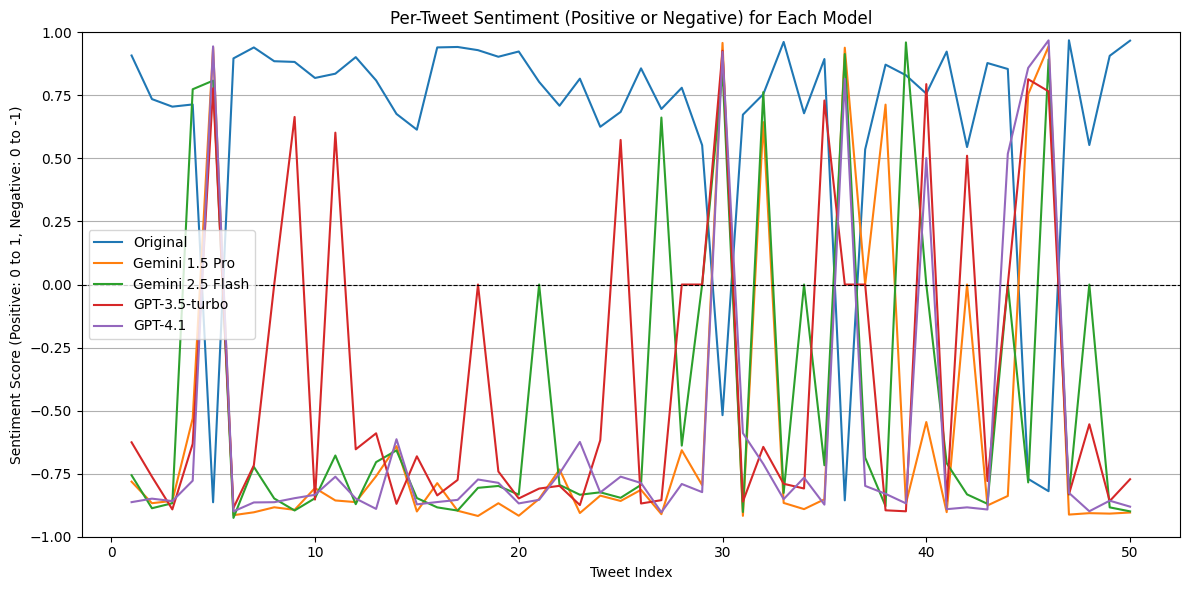

In [34]:
# Plot per-tweet sentiment for all models: positive as-is, negative as negative value, x-axis is tweet index (1-50), one line per model
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load per-tweet sentiment scores
with open("per_tweet_sentiment_scores.json", "r", encoding="utf-8") as f:
    per_tweet_results = json.load(f)

# Prepare data: for each model, build a list of sentiment values (positive or -negative) for each tweet
model_lines = {}
for model, tweet_scores in per_tweet_results.items():
    values = []
    for entry in tweet_scores:
        pos = entry["positive"]
        neg = entry["negative"]
        # Only one of pos or neg is nonzero (by construction)
        if pos > 0 and (neg == 0 or neg is None):
            values.append(pos)
        elif neg > 0 and (pos == 0 or pos is None):
            values.append(-neg)
        else:
            # If both are zero or both nonzero (should not happen), treat as 0
            values.append(0)
    model_lines[model] = values

# Plot
plt.figure(figsize=(12,6))
x = np.arange(1, len(next(iter(model_lines.values())))+1)
for model, y in model_lines.items():
    plt.plot(x, y, marker='', label=model)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Per-Tweet Sentiment (Positive or Negative) for Each Model')
plt.xlabel('Tweet Index')
plt.ylabel('Sentiment Score (Positive: 0 to 1, Negative: 0 to -1)')
plt.ylim(-1, 1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [35]:
# Generate a CSV with one value per tweet per model (from -1 to 1), rows=tweets, columns=datasets
import json
import pandas as pd

with open("per_tweet_sentiment_scores.json", "r", encoding="utf-8") as f:
    per_tweet_results = json.load(f)

# Assume all models have the same number/order of tweets
tweet_count = len(next(iter(per_tweet_results.values())))
models = list(per_tweet_results.keys())

# Build a DataFrame: rows=tweet index, columns=model, value=sentiment (-neg or +pos)
data = {}
for model in models:
    values = []
    for entry in per_tweet_results[model]:
        pos = entry["positive"]
        neg = entry["negative"]
        if pos > 0 and (neg == 0 or neg is None):
            values.append(pos)
        elif neg > 0 and (pos == 0 or pos is None):
            values.append(-neg)
        else:
            values.append(0)
    data[model] = values

df = pd.DataFrame(data)
df.index.name = "tweet_index"
df.to_csv("per_tweet_sentiment_signed.csv")
print("Saved per-tweet signed sentiment values to per_tweet_sentiment_signed.csv (rows=tweets, columns=models, values in [-1,1])")

Saved per-tweet signed sentiment values to per_tweet_sentiment_signed.csv (rows=tweets, columns=models, values in [-1,1])


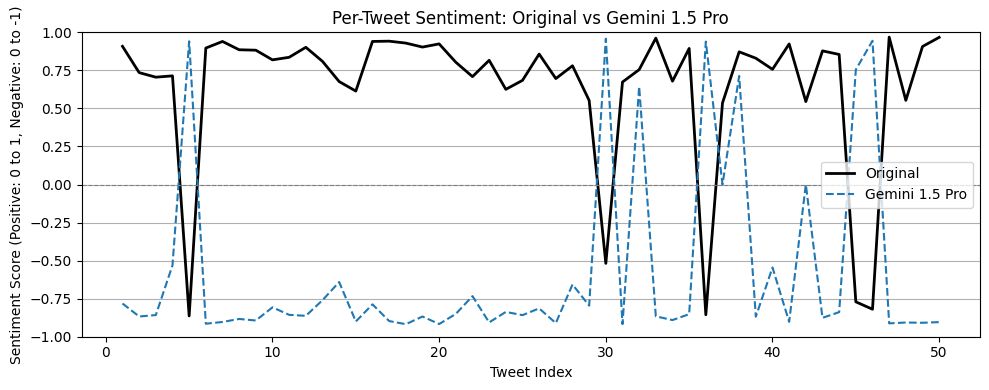

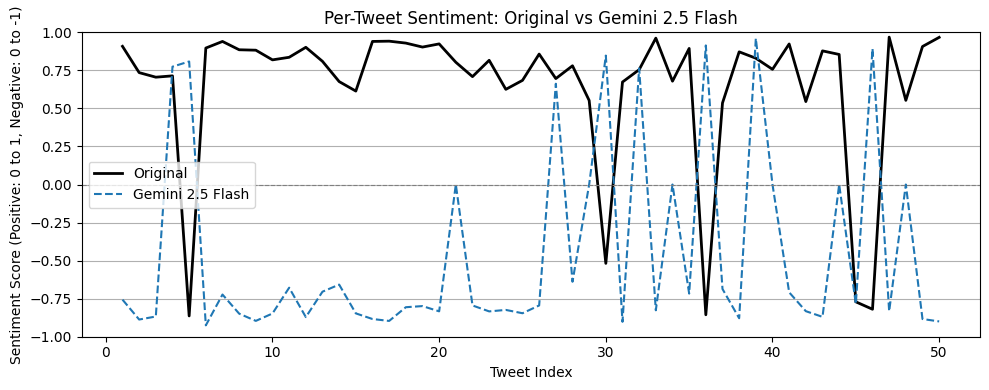

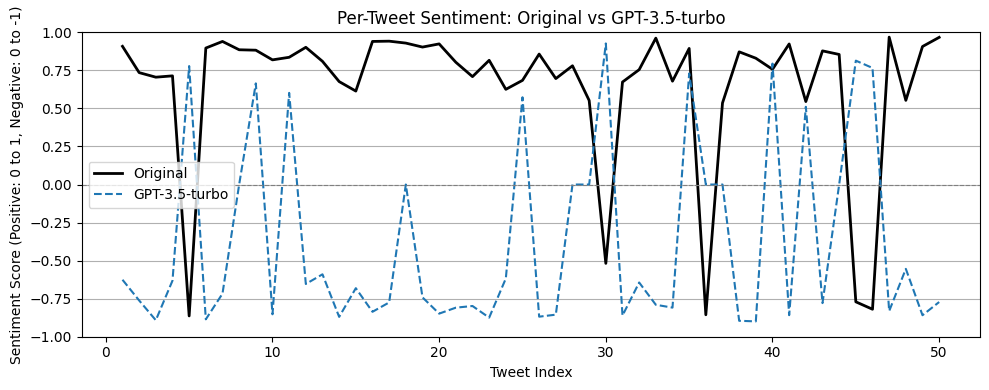

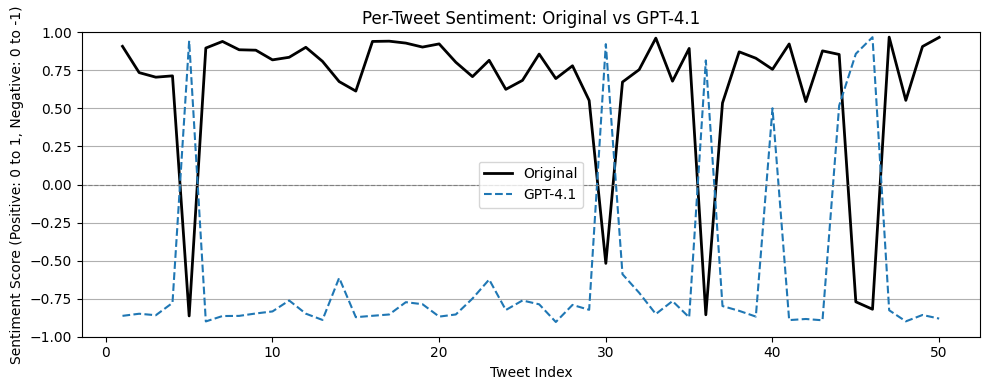

In [36]:
# Plot four graphs: each with the original and one model's per-tweet sentiment line (-1 to 1)
import matplotlib.pyplot as plt
import pandas as pd

# Load the signed sentiment DataFrame
df = pd.read_csv("per_tweet_sentiment_signed.csv", index_col=0)

original_col = [col for col in df.columns if col.lower().startswith("original")][0]
model_cols = [col for col in df.columns if col != original_col]

for model in model_cols:
    plt.figure(figsize=(10,4))
    plt.plot(df.index+1, df[original_col], label='Original', color='black', linewidth=2)
    plt.plot(df.index+1, df[model], label=model, linestyle='--')
    plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    plt.title(f'Per-Tweet Sentiment: Original vs {model}')
    plt.xlabel('Tweet Index')
    plt.ylabel('Sentiment Score (Positive: 0 to 1, Negative: 0 to -1)')
    plt.ylim(-1, 1)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [37]:
# Estimate token usage and API costs for current and 100k tweet generations for each model
import json
import pandas as pd

# Pricing info (USD per 1M tokens)
pricing = {
    'Gemini 1.5 Pro': {'input': 1.25, 'output': 5.00},
    'Gemini 2.5 Flash': {'input': 0.30, 'output': 2.50},
    'GPT-3.5-turbo': {'input': 0.50, 'output': 1.50},
    'GPT-4.1': {'input': 2.00, 'output': 8.00},
}

# File mapping for each model
model_files = {
    'Gemini 1.5 Pro': 'generations_gemini_1_5_pro.json',
    'Gemini 2.5 Flash': 'generations_gemini_2_5_flash.json',
    'GPT-3.5-turbo': 'generations_gpt_3_5_turbo.json',
    'GPT-4.1': 'generations_gpt_4_1.json',
}

# Use tiktoken for OpenAI models, fallback to simple word count for Gemini (approximate)
try:
    import tiktoken
    enc_gpt3 = tiktoken.encoding_for_model('gpt-3.5-turbo')
    enc_gpt4 = tiktoken.encoding_for_model('gpt-4-1106-preview')
except ImportError:
    enc_gpt3 = enc_gpt4 = None

def count_tokens(text, model=None):
    if model == 'GPT-3.5-turbo' and enc_gpt3:
        return len(enc_gpt3.encode(text))
    elif model == 'GPT-4.1' and enc_gpt4:
        return len(enc_gpt4.encode(text))
    else:
        # Approximate: 1 token ≈ 0.75 words (OpenAI), 4 chars/token (Gemini)
        return max(1, int(len(text) / 4))

results = []
for model, file in model_files.items():
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # For each generation, count input (prompt) and output (generated) tokens
    input_tokens = 0
    output_tokens = 0
    for entry in data:
        prompt = entry.get('prompt', '')
        generated = entry.get('generated', '')
        input_tokens += count_tokens(prompt, model)
        output_tokens += count_tokens(generated, model)
    n = len(data)
    # Calculate cost for current run (per 1M tokens)
    input_cost = (input_tokens / 1e6) * pricing[model]['input']
    output_cost = (output_tokens / 1e6) * pricing[model]['output']
    total_cost = input_cost + output_cost
    # Projected cost for 100k tweets
    scale = 100000 / n if n > 0 else 0
    input_tokens_100k = input_tokens * scale
    output_tokens_100k = output_tokens * scale
    input_cost_100k = (input_tokens_100k / 1e6) * pricing[model]['input']
    output_cost_100k = (output_tokens_100k / 1e6) * pricing[model]['output']
    total_cost_100k = input_cost_100k + output_cost_100k
    results.append({
        'Model': model,
        'Tweets': n,
        'Input Tokens': input_tokens,
        'Output Tokens': output_tokens,
        'Input Cost (USD)': input_cost,
        'Output Cost (USD)': output_cost,
        'Total Cost (USD)': total_cost,
        'Input Tokens (100k)': int(input_tokens_100k),
        'Output Tokens (100k)': int(output_tokens_100k),
        'Input Cost (100k, USD)': input_cost_100k,
        'Output Cost (100k, USD)': output_cost_100k,
        'Total Cost (100k, USD)': total_cost_100k,
    })

df_costs = pd.DataFrame(results)
pd.set_option('display.float_format', lambda x: f'$ {x:,.2f}')
print('Token usage and cost estimates for current and 100k tweet generations:')
display(df_costs)

Token usage and cost estimates for current and 100k tweet generations:


,Model,Tweets,Input Tokens,Output Tokens,Input Cost (USD),Output Cost (USD),Total Cost (USD),Input Tokens (100k),Output Tokens (100k),"Input Cost (100k, USD)","Output Cost (100k, USD)","Total Cost (100k, USD)"
0,Gemini 1.5 Pro,50,7322,3098,$ 0.01,$ 0.02,$ 0.02,14644000,6196000,$ 18.30,$ 30.98,$ 49.28
1,Gemini 2.5 Flash,50,7322,3158,$ 0.00,$ 0.01,$ 0.01,14644000,6316000,$ 4.39,$ 15.79,$ 20.18
2,GPT-3.5-turbo,50,7322,2833,$ 0.00,$ 0.00,$ 0.01,14644000,5666000,$ 7.32,$ 8.50,$ 15.82
3,GPT-4.1,50,7322,3007,$ 0.01,$ 0.02,$ 0.04,14644000,6014000,$ 29.29,$ 48.11,$ 77.40


In [44]:
# Display only EUR prices and label 100k columns as '100k tweets'. Euro sign only in cost columns, token columns are plain numbers.
import json
import pandas as pd

USD_EUR = 0.92  # Example: 1 USD = 0.92 EUR
pricing = {
    'Gemini 1.5 Pro': {'input': 1.25, 'output': 5.00},
    'Gemini 2.5 Flash': {'input': 0.30, 'output': 2.50},
    'GPT-3.5-turbo': {'input': 0.50, 'output': 1.50},
    'GPT-4.1': {'input': 2.00, 'output': 8.00},
}
model_files = {
    'Gemini 1.5 Pro': 'generations_gemini_1_5_pro.json',
    'Gemini 2.5 Flash': 'generations_gemini_2_5_flash.json',
    'GPT-3.5-turbo': 'generations_gpt_3_5_turbo.json',
    'GPT-4.1': 'generations_gpt_4_1.json',
}
try:
    import tiktoken
    enc_gpt3 = tiktoken.encoding_for_model('gpt-3.5-turbo')
    enc_gpt4 = tiktoken.encoding_for_model('gpt-4-1106-preview')
except ImportError:
    enc_gpt3 = enc_gpt4 = None
def count_tokens(text, model=None):
    if model == 'GPT-3.5-turbo' and enc_gpt3:
        return len(enc_gpt3.encode(text))
    elif model == 'GPT-4.1' and enc_gpt4:
        return len(enc_gpt4.encode(text))
    else:
        return max(1, int(len(text) / 4))
results = []
for model, file in model_files.items():
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    input_tokens = 0
    output_tokens = 0
    for entry in data:
        prompt = entry.get('prompt', '')
        generated = entry.get('generated', '')
        input_tokens += count_tokens(prompt, model)
        output_tokens += count_tokens(generated, model)
    n = len(data)
    avg_input_tokens = input_tokens / n if n > 0 else 0
    avg_output_tokens = output_tokens / n if n > 0 else 0
    input_cost = (input_tokens / 1e6) * pricing[model]['input'] * USD_EUR
    output_cost = (output_tokens / 1e6) * pricing[model]['output'] * USD_EUR
    total_cost = input_cost + output_cost
    input_tokens_100k = avg_input_tokens * 100000
    output_tokens_100k = avg_output_tokens * 100000
    input_cost_100k = (input_tokens_100k / 1e6) * pricing[model]['input'] * USD_EUR
    output_cost_100k = (output_tokens_100k / 1e6) * pricing[model]['output'] * USD_EUR
    total_cost_100k = input_cost_100k + output_cost_100k
    results.append({
        'Model': model,
        'Tweets': n,
        'Avg Input Tokens/Tweet': round(avg_input_tokens,1),
        'Avg Output Tokens/Tweet': round(avg_output_tokens,1),
        'Input Tokens': int(input_tokens),
        'Output Tokens': int(output_tokens),
        'Input Cost (EUR)': input_cost,
        'Output Cost (EUR)': output_cost,
        'Total Cost (EUR)': total_cost,
        'Input Tokens (100k tweets)': int(input_tokens_100k),
        'Output Tokens (100k tweets)': int(output_tokens_100k),
        'Input Cost (100k tweets, EUR)': input_cost_100k,
        'Output Cost (100k tweets, EUR)': output_cost_100k,
        'Total Cost (100k tweets, EUR)': total_cost_100k,
    })
df_costs = pd.DataFrame(results)

# Format only the cost columns with euro sign, leave token columns as plain numbers
cost_cols = [
    'Input Cost (EUR)', 'Output Cost (EUR)', 'Total Cost (EUR)',
    'Input Cost (100k tweets, EUR)', 'Output Cost (100k tweets, EUR)', 'Total Cost (100k tweets, EUR)'
]
for col in cost_cols:
    df_costs[col] = df_costs[col].apply(lambda x: f'€ {x:,.2f}')

display_cols = [
    'Model', 'Tweets', 'Avg Input Tokens/Tweet', 'Avg Output Tokens/Tweet',
    'Input Tokens', 'Output Tokens',
    'Input Cost (EUR)', 'Output Cost (EUR)', 'Total Cost (EUR)',
    'Input Tokens (100k tweets)', 'Output Tokens (100k tweets)',
    'Input Cost (100k tweets, EUR)', 'Output Cost (100k tweets, EUR)', 'Total Cost (100k tweets, EUR)'
]

# Ensure token columns are displayed as plain numbers (not as currency)
token_cols = [
    'Avg Input Tokens/Tweet', 'Avg Output Tokens/Tweet', 'Input Tokens', 'Output Tokens',
    'Input Tokens (100k tweets)', 'Output Tokens (100k tweets)'
]
for col in token_cols:
    df_costs[col] = df_costs[col].apply(lambda x: f'{x:,}')

print('Token usage and cost estimates for current and 100k tweet generations (EUR only):')
display(df_costs[display_cols])
print('\nToken numbers are calculated from the actual tweets and generations in this notebook. For 100k tweets, the average token count per tweet is assumed to be the same as in the current dataset.')

Token usage and cost estimates for current and 100k tweet generations (EUR only):


,Model,Tweets,Avg Input Tokens/Tweet,Avg Output Tokens/Tweet,Input Tokens,Output Tokens,Input Cost (EUR),Output Cost (EUR),Total Cost (EUR),Input Tokens (100k tweets),Output Tokens (100k tweets),"Input Cost (100k tweets, EUR)","Output Cost (100k tweets, EUR)","Total Cost (100k tweets, EUR)"
0,Gemini 1.5 Pro,50,146.4,62.0,"7,322","3,098",€ 0.01,€ 0.01,€ 0.02,"14,644,000","6,196,000",€ 16.84,€ 28.50,€ 45.34
1,Gemini 2.5 Flash,50,146.4,63.2,"7,322","3,158",€ 0.00,€ 0.01,€ 0.01,"14,644,000","6,316,000",€ 4.04,€ 14.53,€ 18.57
2,GPT-3.5-turbo,50,146.4,56.7,"7,322","2,833",€ 0.00,€ 0.00,€ 0.01,"14,644,000","5,666,000",€ 6.74,€ 7.82,€ 14.56
3,GPT-4.1,50,146.4,60.1,"7,322","3,007",€ 0.01,€ 0.02,€ 0.04,"14,644,000","6,014,000",€ 26.94,€ 44.26,€ 71.21



Token numbers are calculated from the actual tweets and generations in this notebook. For 100k tweets, the average token count per tweet is assumed to be the same as in the current dataset.
